Using device: cuda
Epoch 1/10, Test Accuracy: 0.9764
Epoch 2/10, Test Accuracy: 0.9832
Epoch 3/10, Test Accuracy: 0.9867
Epoch 4/10, Test Accuracy: 0.9897
Epoch 5/10, Test Accuracy: 0.9905
Epoch 6/10, Test Accuracy: 0.9902
Epoch 7/10, Test Accuracy: 0.9911
Epoch 8/10, Test Accuracy: 0.9919
Epoch 9/10, Test Accuracy: 0.9916
Epoch 10/10, Test Accuracy: 0.9920


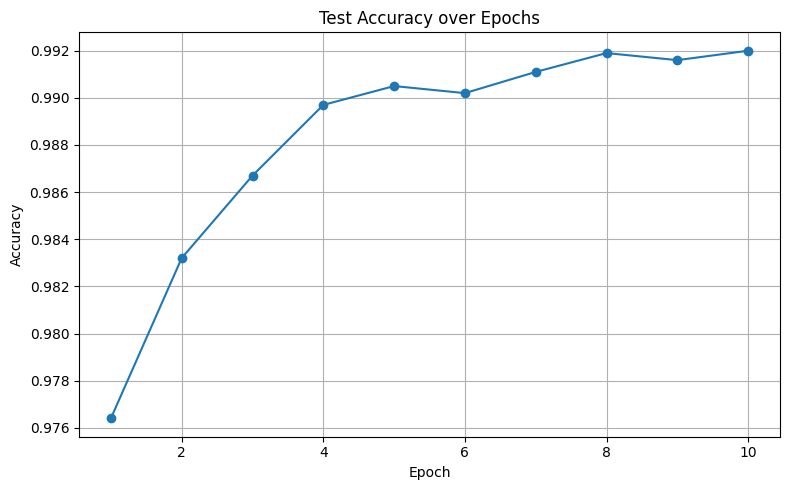

Epoch 1/10, Avg Loss: 0.0162, Test Accuracy: 0.9928
Epoch 2/10, Avg Loss: 0.0142, Test Accuracy: 0.9931
Epoch 3/10, Avg Loss: 0.0130, Test Accuracy: 0.9918
Epoch 4/10, Avg Loss: 0.0114, Test Accuracy: 0.9919
Epoch 5/10, Avg Loss: 0.0106, Test Accuracy: 0.9924
Epoch 6/10, Avg Loss: 0.0089, Test Accuracy: 0.9923
Epoch 7/10, Avg Loss: 0.0084, Test Accuracy: 0.9918
Epoch 8/10, Avg Loss: 0.0074, Test Accuracy: 0.9931
Epoch 9/10, Avg Loss: 0.0067, Test Accuracy: 0.9925
Epoch 10/10, Avg Loss: 0.0066, Test Accuracy: 0.9929


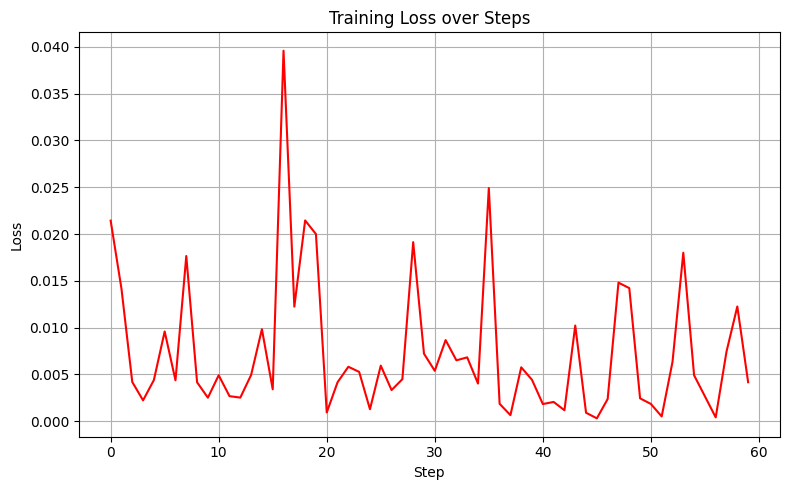

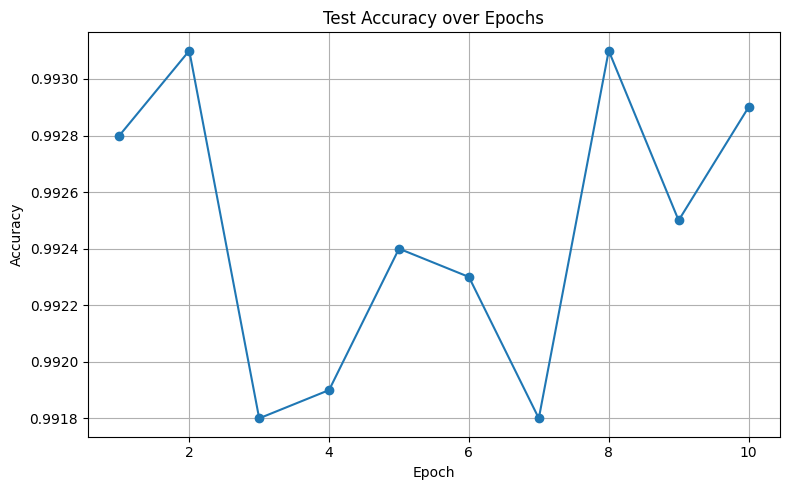

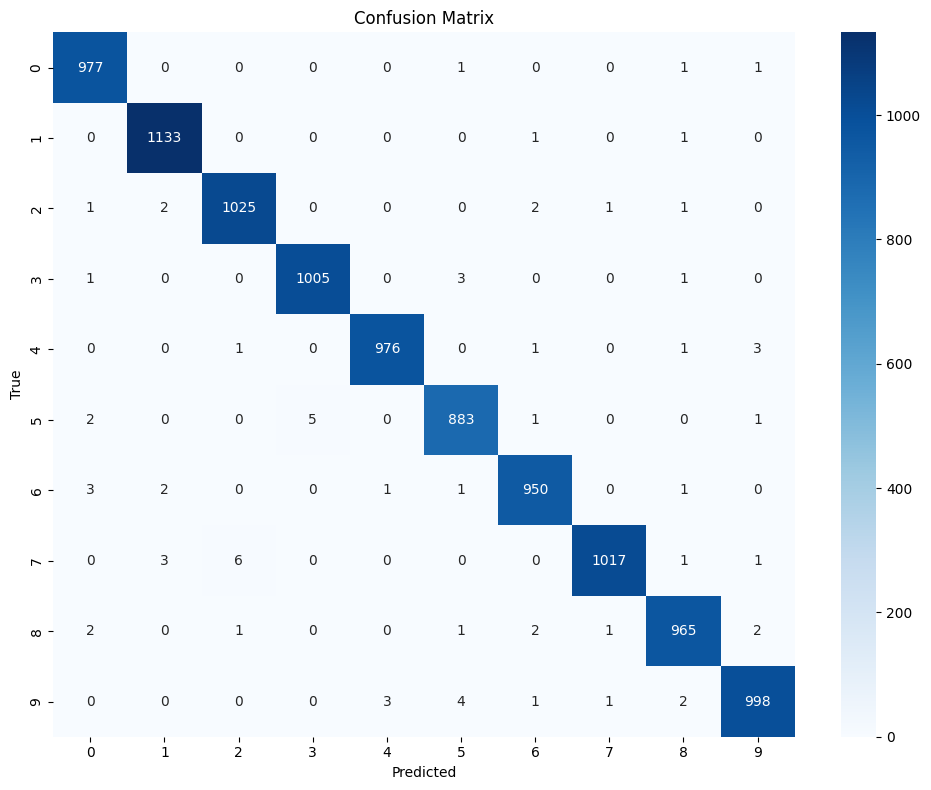

Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.9969    0.9939       980
           1     0.9939    0.9982    0.9960      1135
           2     0.9923    0.9932    0.9927      1032
           3     0.9950    0.9950    0.9950      1010
           4     0.9959    0.9939    0.9949       982
           5     0.9888    0.9899    0.9894       892
           6     0.9916    0.9916    0.9916       958
           7     0.9971    0.9893    0.9932      1028
           8     0.9908    0.9908    0.9908       974
           9     0.9920    0.9891    0.9906      1009

    accuracy                         0.9929     10000
   macro avg     0.9928    0.9928    0.9928     10000
weighted avg     0.9929    0.9929    0.9929     10000



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# --------------------- GPU 设置 ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------- 数据预处理 ---------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000, shuffle=False)

# --------------------- 模型定义 ---------------------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))      # [batch, 32, 28, 28]
        x = F.max_pool2d(x, 2)         # [batch, 32, 14, 14]
        x = F.relu(self.conv2(x))      # [batch, 64, 14, 14]
        x = F.max_pool2d(x, 2)         # [batch, 64, 7, 7]
        x = x.view(-1, 7*7*64)         # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CNN().to(device)

# --------------------- 优化器和损失函数 ---------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.NLLLoss()

# --------------------- 准确率函数 ---------------------
def compute_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

# --------------------- 训练过程 ---------------------
epochs = 10
test_acc_list = []

for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

    acc = compute_accuracy(test_loader)
    test_acc_list.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {acc:.4f}")

# --------------------- 可视化准确率曲线 ---------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_acc_list, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------- 新增：记录 loss 曲线 ---------------------
train_loss_list = []

# --------------------- 训练过程 ---------------------
epochs = 10
test_acc_list = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx%100 == 0:
            train_loss_list.append(loss.item())  # 每100个 batch 的 loss
        epoch_loss += loss.item()
    
    acc = compute_accuracy(test_loader)
    test_acc_list.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {epoch_loss / len(train_loader):.4f}, Test Accuracy: {acc:.4f}")

# --------------------- 可视化：损失变化曲线 ---------------------
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, color='red')
plt.title('Training Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------- 可视化：准确率变化曲线 ---------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_acc_list, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------- 模型评估：混淆矩阵 ---------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --------------------- 打印分类报告 ---------------------
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))
